# Import essential library

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Dataset

In [7]:
resData = pd.read_csv('./Datasets/Cleaned Grab SG Restaurants.csv')
resData.head()

,name,address,cuisine,delivery_cost,lat,lon,opening_hours,radius,rating,reviews_nr,delivery_options,promo,loc_type,delivery_by,delivery_time,total opening time hours
0,Texas Chicken,Texas Chicken - VivoCity,"[""Western"", ""Fast Food"", ""Halal"", ""Chicken"", ""...",570.0,1.264792,103.822103,"{""open"": true, ""displayedHours"": ""10:30-21:30""...",5000,3.8,1591.0,ONLY_DELIVERY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,43.0,75.75
1,Subway,Subway - Vivocity,"[""Healthy"", ""Sandwiches"", ""Fast Food"", ""Halal""...",570.0,1.264741,103.822072,"{""open"": true, ""displayedHours"": ""12:00-19:00""...",3000,4.2,197.0,ONLY_DELIVERY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,42.0,49.00
2,LiHO Tea,LiHO Tea - Vivo City,"[""Same Prices In-Store"", ""Beverages"", ""Local"",...",560.0,1.264309,103.821369,"{""open"": true, ""displayedHours"": ""11:30-20:45""...",5000,4.5,353.0,DELIVERY_TAKEAWAY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,41.0,64.75
3,Wingstop,Wingstop - VivoCity,"[""Halal"", ""Chicken"", ""Fast Food"", ""Burger"", ""W...",560.0,1.263527,103.821712,"{""open"": true, ""displayedHours"": ""11:00-21:00""...",5000,4.4,1391.0,ONLY_DELIVERY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,45.0,70.00
4,Le Shrimp Ramen,Le Shrimp Ramen - Vivocity,"[""Japanese"", ""Ramen"", ""Noodles"", ""Asian""]",570.0,1.264810,103.822554,"{""open"": true, ""displayedHours"": ""10:30-21:00""...",5000,4.6,309.0,DELIVERY_TAKEAWAY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,44.0,73.50


## Delivery Time vs Ratings

Correlation between Delivery Time and Rating: -0.03872272201976687


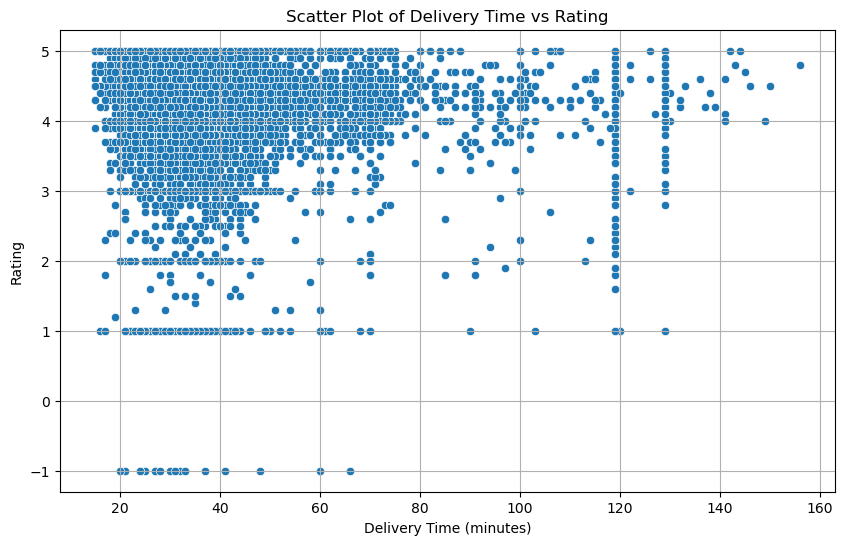

In [9]:
# Drop rows with NaN values in 'rating' or 'delivery_time' for accurate analysis
filtered_data = resData.dropna(subset=['rating', 'delivery_time'])

# Calculate the correlation between 'delivery_time' and 'rating'
correlation = filtered_data['delivery_time'].corr(filtered_data['rating'])

# Display the correlation
print(f"Correlation between Delivery Time and Rating: {correlation}")

# Plotting the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='delivery_time', y='rating', data=filtered_data)
plt.title('Scatter Plot of Delivery Time vs Rating')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

The correlation analysis and visualization between **Delivery Time** and **Rating** show a very weak negative correlation, with a correlation coefficient of approximately **-0.039**. This indicates that while there is a slight tendency for restaurant ratings to decrease as delivery time increases, the relationship is minimal. The scatter plot does not display a strong or clear trend, suggesting that **Delivery Time alone is not a strong predictor** of restaurant ratings. Given the weak correlation, it is likely that other factors significantly influence ratings, and a more complex model might be needed to capture the multifaceted nature of what impacts customer satisfaction.


# Total Opening Hours vs Ratings

Correlation between Total Opening Time Hours and Rating: -0.016420046880103865


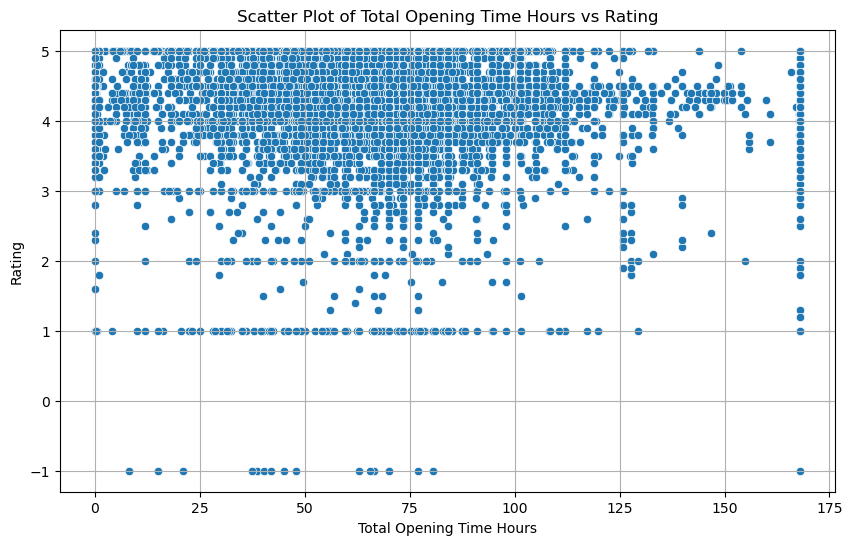

In [11]:
# Drop rows with NaN values in 'rating' or 'total opening time hours' for accurate analysis
filtered_data_hours = resData.dropna(subset=['rating', 'total opening time hours'])

# Calculate the correlation between 'total opening time hours' and 'rating'
correlation_hours = filtered_data_hours['total opening time hours'].corr(filtered_data_hours['rating'])

# Display the correlation
print(f"Correlation between Total Opening Time Hours and Rating: {correlation_hours}")

# Plotting the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total opening time hours', y='rating', data=filtered_data_hours)
plt.title('Scatter Plot of Total Opening Time Hours vs Rating')
plt.xlabel('Total Opening Time Hours')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


The correlation analysis between **Total Opening Time Hours** and **Rating** results in a very weak negative correlation coefficient of approximately **-0.016**. The scatter plot shows no clear trend or significant relationship, indicating that the hours a restaurant is open each day have virtually **no effect on its ratings**. This suggests that **Total Opening Time Hours is not a significant predictor** of restaurant ratings, highlighting the importance of other factors in influencing customer ratings.


### MSE and R^2 values  (Total Opening Hours vs Ratings)

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Prepare the data
data_filtered = resData.dropna(subset=['rating', 'total opening time hours'])

# Features and target
X = data_filtered[['total opening time hours']]
y = data_filtered['rating']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting ratings
y_pred = model.predict(X_test)

# Calculate MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(0.3614741569983696, -0.0012497157207946863)

The linear regression model using **Total Opening Time Hours** as a predictor resulted in a **Mean Squared Error (MSE) of approximately 0.361** and a **Coefficient of Determination (R²) of about -0.0012**. These values indicate that the model has moderate error levels and does not effectively predict restaurant ratings, performing worse than a model that would always predict the average rating. Thus, **Total Opening Time Hours** is not a reliable predictor for restaurant ratings.


# Delivery Options vs Ratings

Unique Delivery Options: ['ONLY_DELIVERY' 'DELIVERY_TAKEAWAY' 'DELIVERY_DINEIN'
 'DELIVERY_TAKEAWAY_DINEIN']

Average Ratings by Delivery Option:
delivery_options
DELIVERY_DINEIN             3.825000
DELIVERY_TAKEAWAY           4.190070
DELIVERY_TAKEAWAY_DINEIN    4.200000
ONLY_DELIVERY               4.399568
Name: rating, dtype: float64


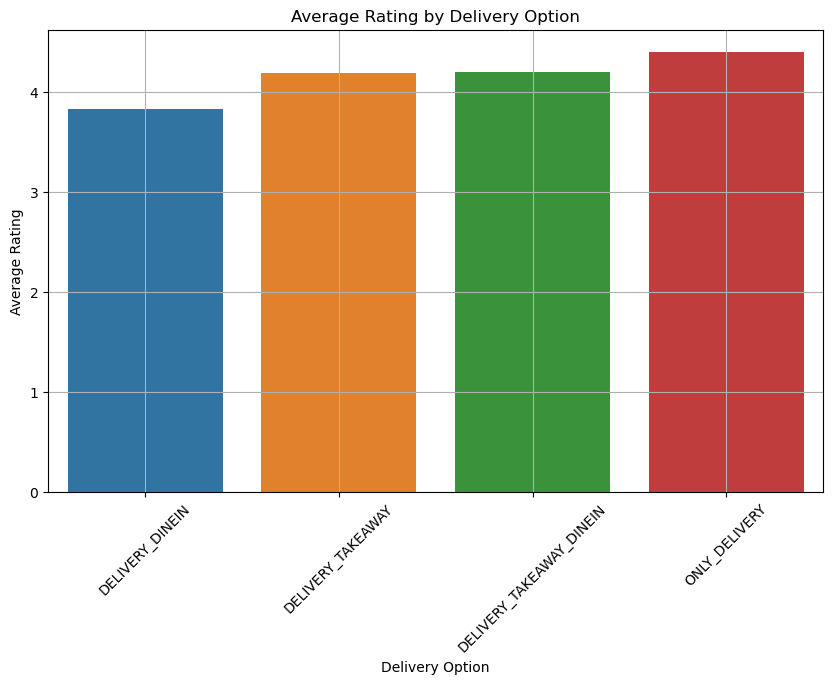

In [13]:
# Inspect the unique categories in the 'delivery_options' column
unique_delivery_options = resData['delivery_options'].unique()

# Calculate the average rating for each delivery option
average_ratings_by_delivery_option = resData.groupby('delivery_options')['rating'].mean().sort_values()

# Display the unique delivery options and their corresponding average ratings
print("Unique Delivery Options:", unique_delivery_options)
print("\nAverage Ratings by Delivery Option:")
print(average_ratings_by_delivery_option)

# Plotting the relationship
plt.figure(figsize=(10, 6))
sns.barplot(x=average_ratings_by_delivery_option.index, y=average_ratings_by_delivery_option.values)
plt.title('Average Rating by Delivery Option')
plt.xlabel('Delivery Option')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


The analysis of **Delivery Options** shows significant variation in average restaurant ratings associated with different service types. The highest average rating is observed for **ONLY_DELIVERY** at approximately **4.40**, followed by **DELIVERY_TAKEAWAY_DINEIN** at **4.20**, **DELIVERY_TAKEAWAY** at **4.19**, and **DELIVERY_DINEIN** at **3.83**. This indicates that delivery options are a notable predictor of restaurant ratings, with specialized delivery services possibly yielding higher customer satisfaction. The visual comparison using a bar plot further underscores the importance of tailored service options in influencing customer ratings.


### MSE and R^2 value (Delivery Options vs Ratings)

In [20]:
from sklearn.preprocessing import OneHotEncoder

# Prepare the data by dropping NaN values
data_filtered_delivery_options = resData.dropna(subset=['rating', 'delivery_options'])

# One-hot encoding 'delivery_options'
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(data_filtered_delivery_options[['delivery_options']]).toarray()
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(['delivery_options']))

# Target variable
y_delivery_options = data_filtered_delivery_options['rating']

# Splitting the data
X_train_do, X_test_do, y_train_do, y_test_do = train_test_split(X_encoded_df, y_delivery_options, test_size=0.2, random_state=42)

# Create a linear regression model
model_do = LinearRegression()
model_do.fit(X_train_do, y_train_do)

# Predicting ratings
y_pred_do = model_do.predict(X_test_do)

# Calculate MSE and R²
mse_do = mean_squared_error(y_test_do, y_pred_do)
r2_do = r2_score(y_test_do, y_pred_do)

mse_do, r2_do


(0.35129769481535, 0.026938135804750907)

The regression model with **Delivery Options** as predictors resulted in a **Mean Squared Error (MSE) of approximately 0.351** and a **Coefficient of Determination (R²) of about 0.0269**. These values indicate moderate prediction error and a slight ability to explain the variability in restaurant ratings, accounting for about 2.69% of the variance. This demonstrates that while **Delivery Options** have some influence on ratings, their predictive power is limited, suggesting that other factors also play significant roles in influencing restaurant ratings.


In analyzing "Delivery Options" as predictors for restaurant ratings, we employed **OneHotEncoder** to convert categorical data into a numerical format suitable for regression models. This technique creates binary columns for each category, essential for incorporating categorical variables into machine learning algorithms, which typically require numerical input.

The regression model, post-encoding, achieved a **Mean Squared Error (MSE) of approximately 0.351** and a **Coefficient of Determination (R²) of about 0.0269**. These results suggest a moderate predictive accuracy, with "Delivery Options" explaining about 2.69% of the variance in ratings. While the influence is limited, it indicates some potential for predictiveness, highlighting the importance of integrating additional variables for enhanced model performance.


# Location Type vs Ratings

### Calculate the count for **FOOD** and **MART**

In [24]:
location_type_counts = resData['loc_type'].value_counts()
location_type_counts

loc_type
FOOD    13819
MART     2317
Name: count, dtype: int64

### Find average ratings between these columns

Unique Location Types: ['FOOD' 'MART']

Average Ratings by Location Type:
loc_type
FOOD    4.201246
MART    4.503138
Name: rating, dtype: float64


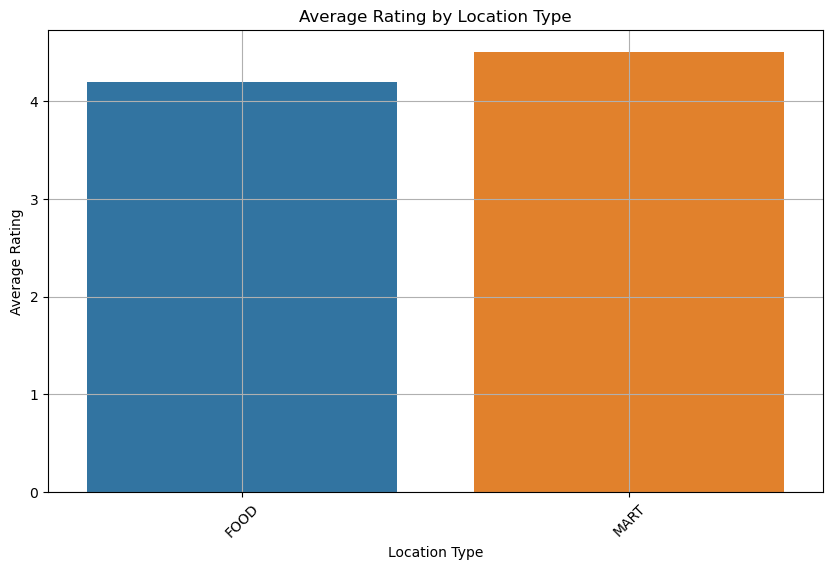

In [25]:
# Inspect the unique categories in the 'loc_type' column
unique_location_types = resData['loc_type'].unique()

# Calculate the average rating for each location type
average_ratings_by_location_type = resData.groupby('loc_type')['rating'].mean().sort_values()

# Display the unique location types and their corresponding average ratings
print("Unique Location Types:", unique_location_types)
print("\nAverage Ratings by Location Type:")
print(average_ratings_by_location_type)

# Plotting the relationship
plt.figure(figsize=(10, 6))
sns.barplot(x=average_ratings_by_location_type.index, y=average_ratings_by_location_type.values)
plt.title('Average Rating by Location Type')
plt.xlabel('Location Type')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


The evaluation of **Location Type** reveals distinct differences in average ratings: **MART** locations have a higher average rating of approximately **4.50**, compared to **FOOD** locations, which have an average rating of about **4.20**. This distinction suggests that location type is a notable predictor of restaurant ratings, with specialized or niche markets (`MART`) potentially providing higher customer satisfaction. The bar plot visually confirms the substantial impact of location type on customer ratings, highlighting the importance of understanding different customer expectations and experiences across various types of establishments.


### MSE vs R^2 (Location Type vs Ratings)

In [22]:
# Filtering data to ensure no NaN values in 'rating'
data_filtered_loc_type = resData.dropna(subset=['rating'])

# One-hot encoding 'loc_type' after filtering
X_encoded_loc_filtered = encoder.fit_transform(data_filtered_loc_type[['loc_type']]).toarray()
X_encoded_loc_filtered_df = pd.DataFrame(X_encoded_loc_filtered, columns=encoder.get_feature_names_out(['loc_type']))

# Correctly aligned target variable for location type
y_loc_type_filtered = data_filtered_loc_type['rating']

# Splitting the data correctly
X_train_lt_filtered, X_test_lt_filtered, y_train_lt_filtered, y_test_lt_filtered = train_test_split(
    X_encoded_loc_filtered_df, y_loc_type_filtered, test_size=0.2, random_state=42)

# Recreate and fit the linear regression model for location type
model_lt_filtered = LinearRegression()
model_lt_filtered.fit(X_train_lt_filtered, y_train_lt_filtered)

# Predicting ratings with the correctly filtered data
y_pred_lt_filtered = model_lt_filtered.predict(X_test_lt_filtered)

# Recalculate MSE and R² for location type with the correct data alignment
mse_lt_filtered = mean_squared_error(y_test_lt_filtered, y_pred_lt_filtered)
r2_lt_filtered = r2_score(y_test_lt_filtered, y_pred_lt_filtered)

mse_lt_filtered, r2_lt_filtered


(0.3484602703161967, 0.034797537142726265)

The regression model with **Location Type** as predictors achieved a **Mean Squared Error (MSE) of approximately 0.348** and a **Coefficient of Determination (R²) of about 0.0351**. These results suggest a moderate predictive accuracy, with "Location Type" explaining only about 3.51% of the variance in ratings. While there is a slight predictive capability, "Location Type" alone does not strongly predict restaurant ratings, indicating the need for incorporating more variables into the model for improved prediction accuracy.


# Delivery Cost vs Ratings

Correlation between Delivery Cost and Rating: -5.742286107849148e-05


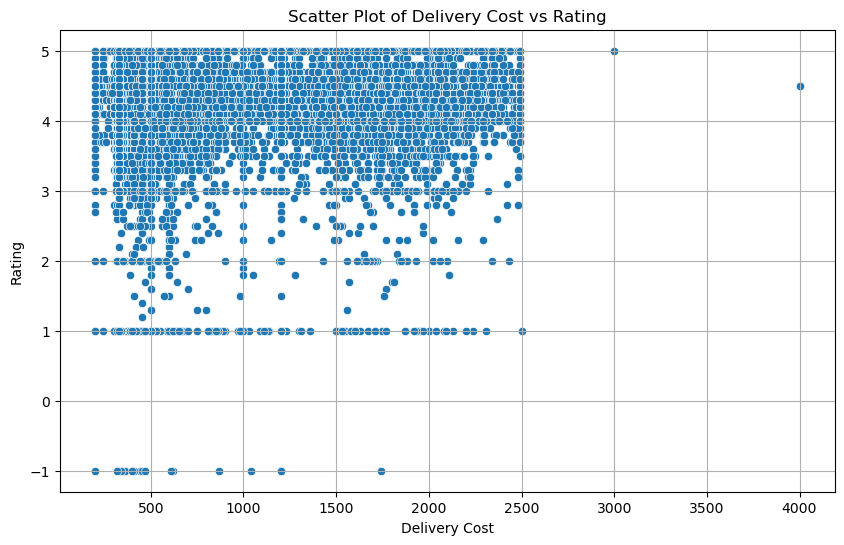

In [27]:
# Prepare the data by dropping NaN values for delivery cost and rating
data_filtered_delivery_cost = resData.dropna(subset=['rating', 'delivery_cost'])

# Calculate the correlation between 'delivery_cost' and 'rating'
correlation_delivery_cost = data_filtered_delivery_cost['delivery_cost'].corr(data_filtered_delivery_cost['rating'])

# Display the correlation
print(f"Correlation between Delivery Cost and Rating: {correlation_delivery_cost}")

# Plotting the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='delivery_cost', y='rating', data=data_filtered_delivery_cost)
plt.title('Scatter Plot of Delivery Cost vs Rating')
plt.xlabel('Delivery Cost')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


### MSE and R^2 Value (Delivery Cost vs Ratings)

In [28]:
# Features and target for delivery cost
X_cost = data_filtered_delivery_cost[['delivery_cost']]
y_cost = data_filtered_delivery_cost['rating']

# Splitting the data
X_train_cost, X_test_cost, y_train_cost, y_test_cost = train_test_split(X_cost, y_cost, test_size=0.2, random_state=42)

# Create a linear regression model for delivery cost
model_cost = LinearRegression()
model_cost.fit(X_train_cost, y_train_cost)

# Predicting ratings
y_pred_cost = model_cost.predict(X_test_cost)

# Calculate MSE and R² for delivery cost
mse_cost = mean_squared_error(y_test_cost, y_pred_cost)
r2_cost = r2_score(y_test_cost, y_pred_cost)

mse_cost, r2_cost


(0.38464467567069527, -0.00010467161838745298)

The linear regression model using **Delivery Cost** as a predictor resulted in a **Mean Squared Error (MSE) of approximately 0.385** and a **Coefficient of Determination (R²) of about -0.0001**. These results indicate moderate prediction error and no explanatory power, as the model fails to account for any variance in ratings and performs worse than a naive mean-based model. Consequently, **Delivery Cost** does not appear to be a reliable predictor for restaurant ratings, suggesting that other factors are more influential in determining customer satisfaction and ratings.


# Top Cuisine vs Ratings

In [34]:
import ast  # For safely evaluating strings that contain Python literals

# Check if 'cuisine' needs cleaning and evaluate the structure
resData['cuisine'].head()

# Assuming 'cuisine' contains string representations of lists, we'll convert these to actual lists
resData['cuisine_list'] = resData['cuisine'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

# Explode the 'cuisine_list' into separate rows for each cuisine per restaurant, to better analyze the impact of each cuisine
data_exploded = resData.explode('cuisine_list')

# Check the top cuisines and their frequencies to decide how to encode them
cuisine_counts = data_exploded['cuisine_list'].value_counts()
print(cuisine_counts.head(10))

# To limit the number of dummy variables, we might consider only the top N cuisines or group less frequent ones into an 'Other' category
top_cuisines = cuisine_counts.nlargest(10).index.tolist()
data_exploded['top_cuisine'] = data_exploded['cuisine_list'].apply(lambda x: x if x in top_cuisines else 'Other')

# Verify the new column and prepare for encoding
print(data_exploded[['top_cuisine']].head(10))



cuisine_list
Asian        4465
Local        4332
Chinese      3889
Western      2498
Noodles      2126
Beverages    2035
Mart         2027
Chicken      1950
Halal        1612
Seafood      1519
Name: count, dtype: int64
  top_cuisine
0     Western
0       Other
0       Halal
0     Chicken
0   Beverages
1       Other
1       Other
1       Other
1       Halal
1     Western


In [35]:
# One-hot encoding the 'top_cuisine' categories
encoder_cuisine = OneHotEncoder(sparse=False)
X_encoded_cuisine = encoder_cuisine.fit_transform(data_exploded[['top_cuisine']])
X_encoded_cuisine_df = pd.DataFrame(X_encoded_cuisine, columns=encoder_cuisine.get_feature_names_out(['top_cuisine']))

# Prepare the target variable for the exploded data
y_cuisine = data_exploded['rating'].dropna()

# Since we need to align the data correctly for model training
X_encoded_cuisine_df = X_encoded_cuisine_df.loc[y_cuisine.index]

# Splitting the data
X_train_cuisine, X_test_cuisine, y_train_cuisine, y_test_cuisine = train_test_split(
    X_encoded_cuisine_df, y_cuisine, test_size=0.2, random_state=42)

# Create a linear regression model for cuisine types
model_cuisine = LinearRegression()
model_cuisine.fit(X_train_cuisine, y_train_cuisine)

# Predicting ratings
y_pred_cuisine = model_cuisine.predict(X_test_cuisine)

# Calculate MSE and R² for cuisine types
mse_cuisine = mean_squared_error(y_test_cuisine, y_pred_cuisine)
r2_cuisine = r2_score(y_test_cuisine, y_pred_cuisine)

mse_cuisine, r2_cuisine


C:\Users\tq121\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(0.3722204304439892, 0.0006406664833527032)

The regression model assessing the impact of **Cuisine** on restaurant ratings resulted in a **Mean Squared Error (MSE) of approximately 0.372** and a **Coefficient of Determination (R²) of about 0.00067**. These values indicate a moderate level of prediction error and demonstrate that "Cuisine" explains only a negligible fraction of the variance in ratings. This suggests that "Cuisine" alone is not a significant predictor of restaurant ratings, pointing to the importance of considering additional factors in predictive models for restaurant ratings.


# Radius vs Rating

Correlation between Radius and Rating: 0.022407720524875656


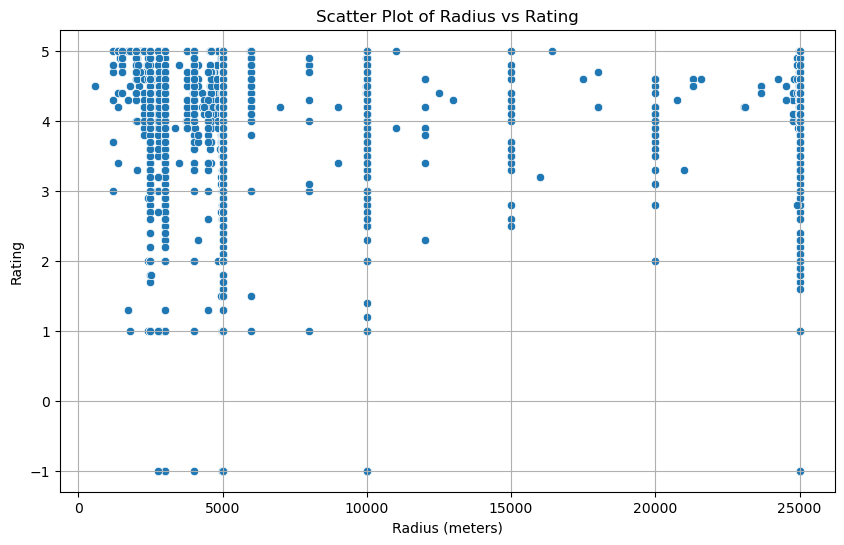

In [37]:
# Prepare the data by dropping NaN values for radius and rating
data_filtered_radius = resData.dropna(subset=['rating', 'radius'])

# Calculate the correlation between 'radius' and 'rating'
correlation_radius = data_filtered_radius['radius'].corr(data_filtered_radius['rating'])

# Display the correlation
print(f"Correlation between Radius and Rating: {correlation_radius}")

# Plotting the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='radius', y='rating', data=data_filtered_radius)
plt.title('Scatter Plot of Radius vs Rating')
plt.xlabel('Radius (meters)')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


### MSE and R^2 Value (Delivery Cost vs Ratings)